**Ritajit Majumdar**<br>
Enabling Technologies Researcher @ IBM Quantum<br>
majumdar.ritajit@ibm.com

## Understanding dynamical decoupling on hardware

In this notebook we shall take a circuit of interest, vary its number of qubits and depth, and apply dynamical decoupling (DD) on it. The aim of this exercise is to get a feel for

<ul>
    <li>In which scenario applying DD leads to effective error suppression</li>
    <li>Which DD sequence is most effective</li>
</ul>

For this study we shall select a TwoLocal circuit which is often used in problems related to quantum chemistry and quantum machine learning. Moreover, we shall use a compute-uncompute version of the circuit. In this, the circuit unitary $U$ is followed by $U^{\dagger}$ so that the ideal noiseless outcome is $|0\rangle^{\otimes n}$ for an $n$-qubit circuit.

The advantage of such a circuit is that the ideal expectation values for $Z$ type observables are known without explicit simulation which is not possible for utility-scale circuits. The disadvantage is that having an uncompute unitary doubles the depth of the base circuit.

## Qiskit Pattern

### Step 1: Map problem to quantum hardware native format

**Virtual circuit**

We start by declaring an example circuit. Feel free to change it to something else.

We select the TwoLocal circuit which has alternate layers of single and two qubit gates. The number of single qubit gate layers may be more than one, depending on the types of parameterized gates used. The two qubit gate layers can also vary depending on the type of entanglement. Such a layer can be repeated multiple times. For this notebook, we shall use a TwoLocal circuit with `Ry` as the parameterized gate, and `linear` entanglement with one repetition.

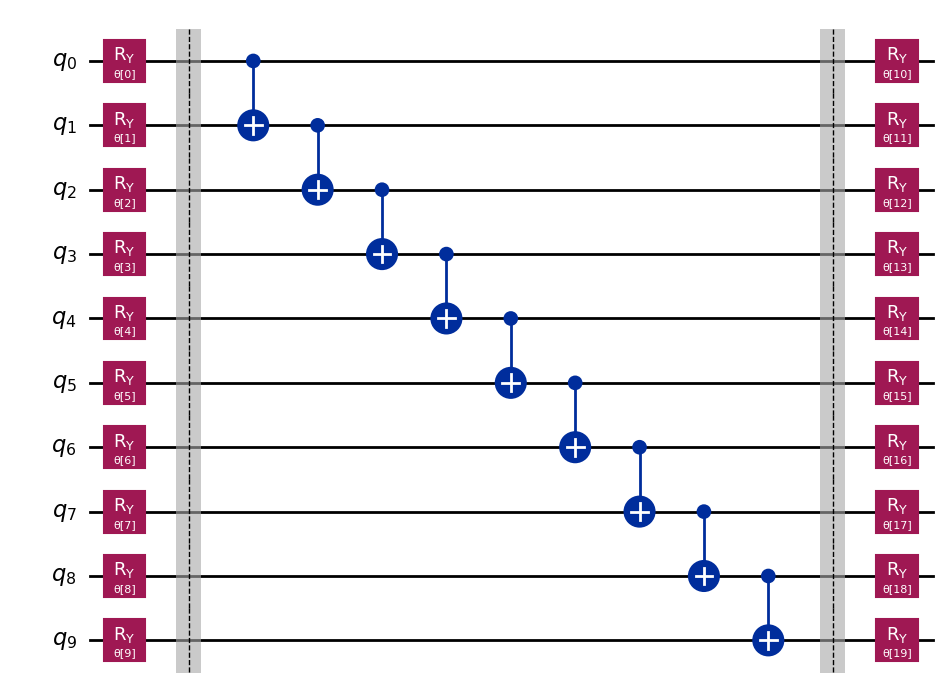

In [2]:
from qiskit.circuit.library import TwoLocal

num_qubits = 10
reps = 1
rotation_blocks = 'ry'
entanglement_blocks = 'cx'
entanglement = 'linear'

virtual_circuit = TwoLocal(num_qubits=num_qubits, reps=reps, rotation_blocks=rotation_blocks, 
                   entanglement_blocks=entanglement_blocks, entanglement=entanglement,
                  insert_barriers=True)
virtual_circuit = virtual_circuit.decompose()

virtual_circuit.draw('mpl', fold=-1)

#### Create compute-uncompute circuit

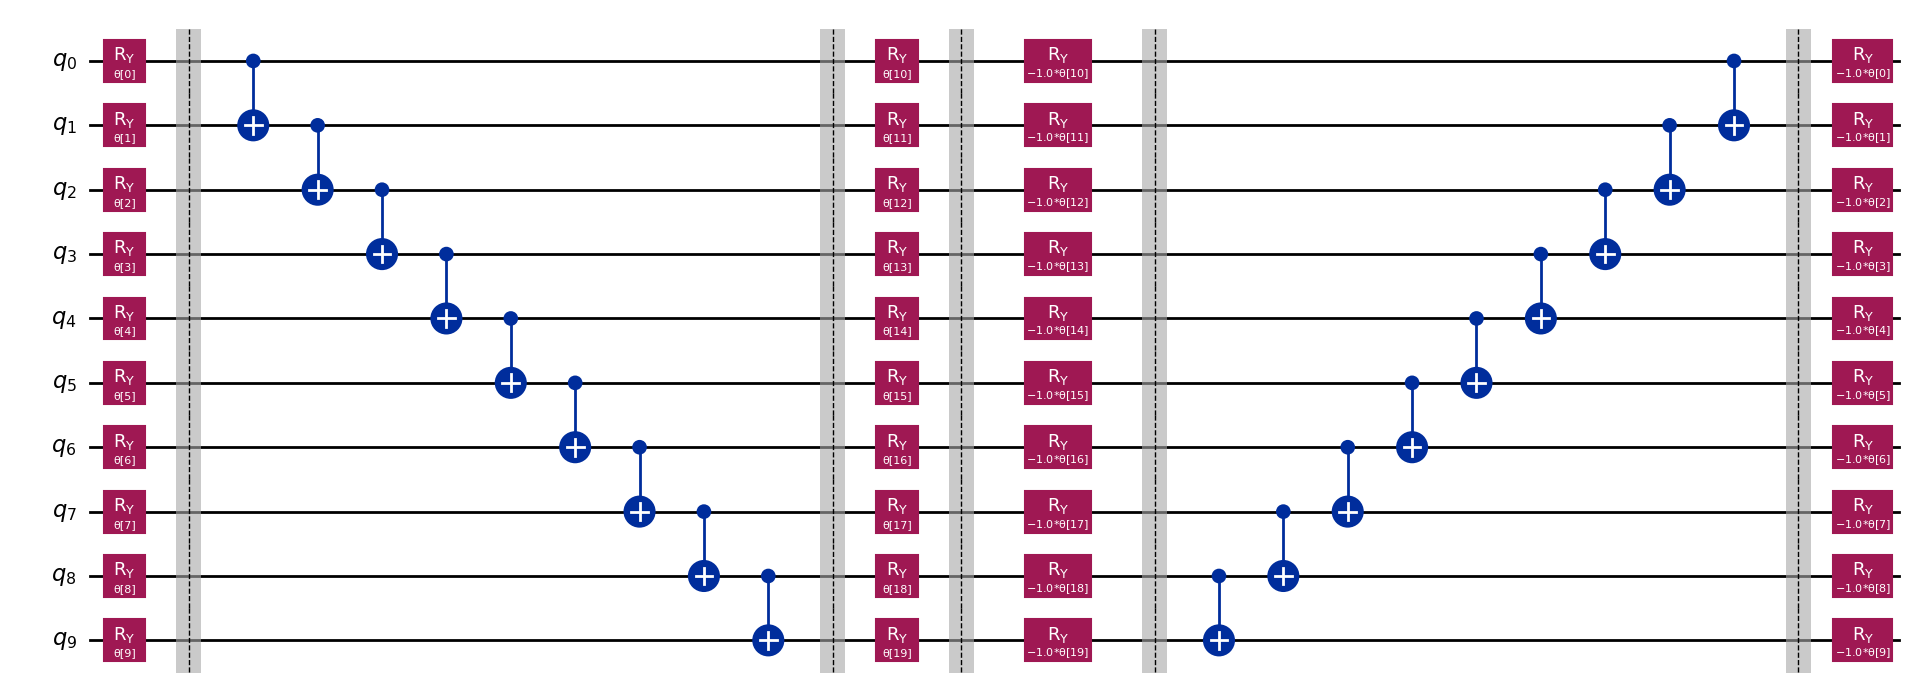

In [3]:
inverse = virtual_circuit.inverse()
virtual_circuit.barrier()
virtual_circuit.compose(inverse, inplace=True)

virtual_circuit.draw('mpl',fold=-1)

#### Assign parameters

We shall assign parameters randomly to this circuit. Note that since the circuit is of type compute-uncompute, the ideal outcome of the circuit is independent of the exact values of the parameters.

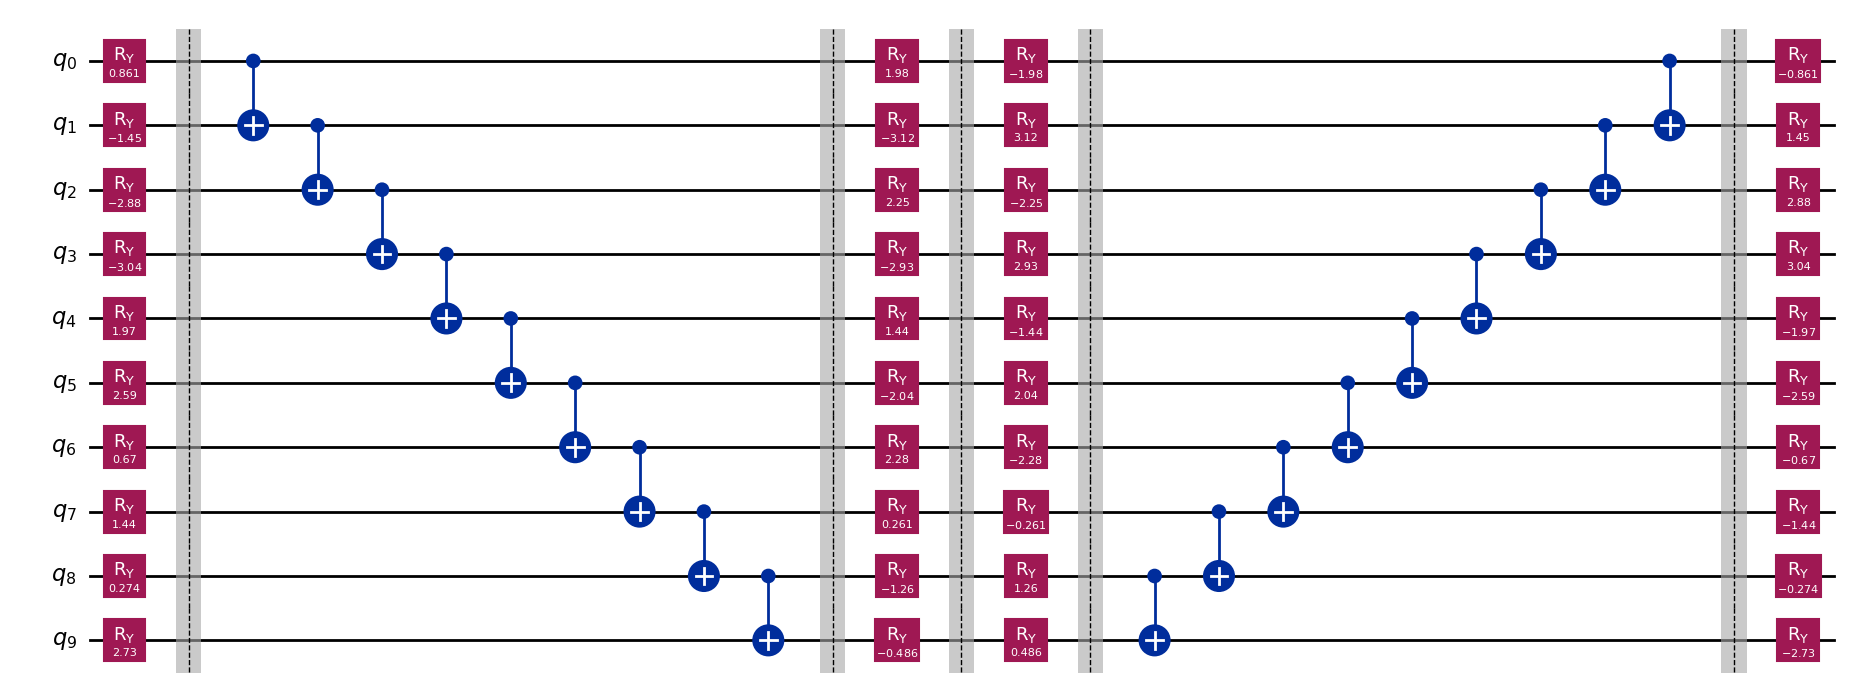

In [4]:
from numpy import pi
from numpy.random import default_rng

rng = default_rng(seed=0)
parameter_values = rng.uniform(-pi, pi, size=virtual_circuit.num_parameters)
virtual_circuit.assign_parameters(parameter_values, inplace=True)

virtual_circuit.draw(output='mpl', fold=-1)

#### Observables

Let us select the average of all weight-1 Pauli-Z observables for this example. Note that by nature of the compute-uncompute circuit the ideal value is exactly 1.

In [5]:
from qiskit.quantum_info import SparsePauliOp

paulis = ['I'*i + 'Z' + 'I'*(num_qubits-i-1) for i in range(num_qubits)]
coeffs = 1/len(paulis)

observable = SparsePauliOp(paulis, coeffs)
print(observable)

SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'],
              coeffs=[0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j])


### Step 2: Optimize circuit and observable

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()  # Credentials may be needed
backend = service.get_backend('ibm_kyiv')  # Choose your desired backend

#### Physical circuit (transpilation)

In order to execute the logical circuit on actual hardware we need to express it in terms of the hardware's native gates (i.e. Instruction Set Architecture, ISA), as well as assign physical qubits for execution. This action is carried out through the process of circuit transpilation.

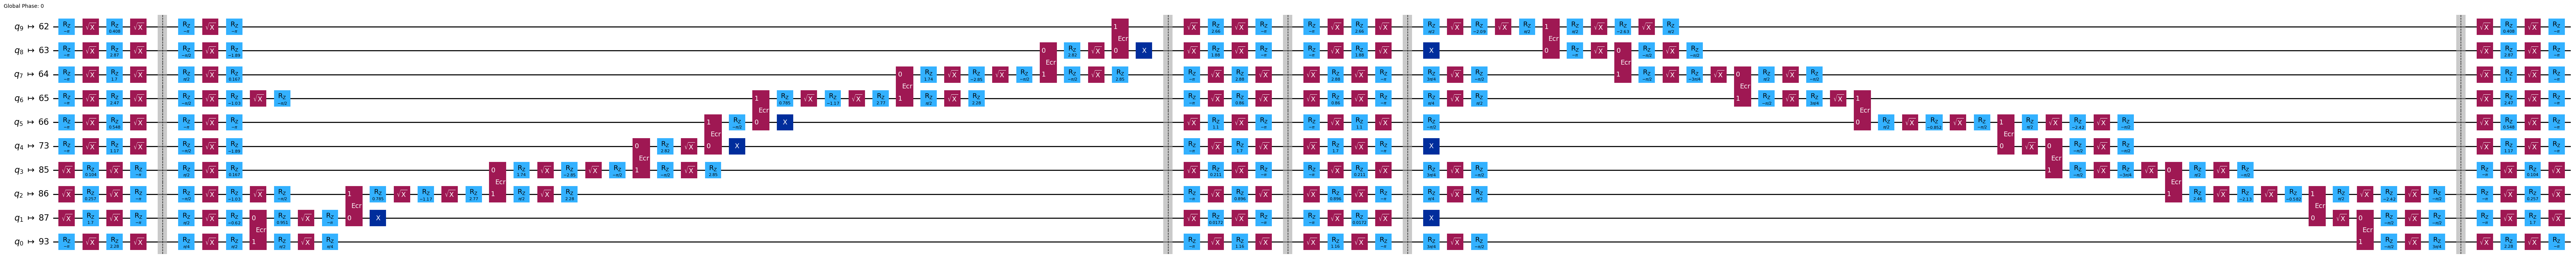

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
physical_circuit = pm.run(virtual_circuit)

physical_circuit.draw(output='mpl', fold=-1, idle_wires=False)

#### Physical observable (layout)

In the same way that we needed to adapt our logical circuit to the hardware, we will need to adapt the associated logical observable in an equivalent way. The resulting physical observable will need to account for the additional qubits in the hardware, as well as for any routing that the logical qubits may have experienced when mapped on to physical ones. This can be easily done by applying the physical circuit's layout to the logical observable. We refer to this process as *observable layout*.

In [8]:
physical_layout = physical_circuit.layout
physical_observable = observable.apply_layout(physical_layout)

print(physical_observable)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIII

### Step 3: Execute using Qiskit Primitives

#### Dynamical decoupling

Note that in the original circuit, most of the qubits remain idle for a significant amount of time while other qubits are involved in gate operations. Such idle qubits are susceptible to crosstalk appearing from the gate operations on other qubits. Therefore, dynamical decoupling appends some single qubit gate operations on these idle timespans to avoid such crosstalk. The sequence of gates appended to the idle timestamp must cummulatively lead to identity to ensure functional equivalence.

#### Execute

Now we shall execute the circuit using an `EstimatorV2` primitive. The dynamical decoupling shall be applied using the primitive itself. Qiskit currently allows three DD sequences -- namely `XX`, `XpXm` and `XY4`. We shall run the circuit with each of these DD sequence, and also without any DD. We shall not use any other error mitigation or suppression technique for this notebook.

In [14]:
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()

options.default_shots = 4096
options.optimization_level = 0  # Deactivate error suppression
options.resilience_level = 0  # Deactivate error mitigation

In [17]:
from qiskit_ibm_runtime import Batch, EstimatorV2

jobs = {}
with Batch(backend=backend) as batch:
    estimator = EstimatorV2(session=batch, options=options)
    pub = (physical_circuit, physical_observable)

    # No DD
    estimator.options.dynamical_decoupling.enable = False
    jobs['no_dd'] = estimator.run([pub])

    # DD with XX pulse sequence
    dd_sequence = 'XX'
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = dd_sequence
    jobs[dd_sequence] = estimator.run([pub])

    # DD with XpXm pulse sequence
    dd_sequence = 'XpXm'
    estimator.options.dynamical_decoupling.sequence_type = dd_sequence
    jobs[dd_sequence] = estimator.run([pub])

    # DD with XY4 pulse sequence
    dd_sequence = 'XY4'
    estimator.options.dynamical_decoupling.sequence_type = dd_sequence
    jobs[dd_sequence] = estimator.run([pub])

In [18]:
print("JOB IDS:")
for dd_sequence, job in jobs.items():
    print(f"  - {job.job_id()} ({dd_sequence})")

JOB IDS:
  - csc0ew33dkhg008ze3m0 (no_dd)
  - csc0ewkzx1qg008m9hs0 (XX)
  - csc0ex3tj7dg008cbcs0 (XpXm)
  - csc0exbx35wg0080yk3g (XY4)


### Step 4: Postprocess

Let us observe the expectation values obtained for different DD sequences

In [20]:
results = {dd_sequence: job.result()[0] for dd_sequence, job in jobs.items()}
evs = {dd_sequence: result.data.evs.tolist() for dd_sequence, result in results.items()}

print("EXPECTATION VALUES:")
for dd_sequence, ev in evs.items():
    print(f"  - {ev} ({dd_sequence})")

EXPECTATION VALUES:
  - 0.19667968750000003 (no_dd)
  - 0.574072265625 (XX)
  - 0.5982910156250001 (XpXm)
  - 0.6757324218749999 (XY4)


### Practice

Challenge questions to come